In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv


In [77]:
## load the libraries 
import tensorflow as tf
import keras
from keras.layers import Layer, Dense, Input, Conv2D, Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D , Flatten ,BatchNormalization , Dropout, LeakyReLU, Activation, Lambda
from keras.optimizers import RMSprop ,Adam

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
from keras.utils.np_utils import to_categorical
from keras import metrics, backend as K

import numpy as np

In [78]:
### read dataset 
train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
test  = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")
train_x = train[list(train.columns)[1:]].values
train_label = train['label'].values
test_label=test["label"].values
test_x=test[list(test.columns)[1:]].values


## normalize and reshape the predictors  
train_x = train_x / 255
test_x = test_x/255


## reshape the inputs
train_x = train_x.reshape(-1, 28,28,1)
test_x = test_x.reshape(-1, 28,28,1)

In [79]:
train_x.shape , test_x.shape, train_label.shape, test_label.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

In [80]:
train_X,valid_X,train_ground,valid_ground = train_test_split(train_x,
                                                             train_x,
                                                             test_size=0.2,
                                                             random_state=13)

In [81]:
train_X.shape, valid_X.shape, train_ground.shape, valid_ground.shape

((48000, 28, 28, 1),
 (12000, 28, 28, 1),
 (48000, 28, 28, 1),
 (12000, 28, 28, 1))

In [82]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [83]:
def KL_Divergence(mean, log_sigma):
    return - 0.5 * tf.reduce_mean((1 + log_sigma - tf.square(mean) - tf.exp(log_sigma)))

In [84]:
def encoder(kernel, n_filter, rows, cols, channels, latent_dim):
    input_data = Input(shape=(rows, cols, channels))
    model = Conv2D(filters=n_filter, kernel_size=kernel, strides=2, padding='same')(input_data) #14x14x32
    #model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)
    #model = MaxPooling2D(pool_size=(2, 2))(model) #14x14x32
    model = Dropout(0.2)(model)


    model = Conv2D(filters=n_filter*2, kernel_size=kernel, strides=2, padding='same')(model) #7x7x64
    #model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.2)(model)

    model = Flatten()(model) # 7 x 7 x 64 = ?
    
    model = Dense(latent_dim * 2)(model) #512
    #model = LeakyReLU(alpha=0.2)(model)
    #model = Dropout(0.5)(model)
    
    #Use output as mean and log_sigma to create latent code (Gaussian distribution by using sampling func)
    mean = Dense(latent_dim)(model) # shape = 128
    log_sigma = Dense(latent_dim)(model) #shape = 128
    latent_code = Sampling()([mean, log_sigma])
    encoder = Model([input_data], [mean, log_sigma, latent_code])
    return encoder

In [85]:
def decoder(kernel, n_filter, rows, cols, channnels, latent_dim):
    latent_code = Input(shape=(latent_dim,))#latent_code has shape = latent_dim
    model = Dense(n_filter*2*(rows//4)*(cols//4))(latent_code) # 7 x 7 x 64 = ? (cols and rows divide by 4 cuz 
                                                                    # we use 2 times Downsampling in Encoder)
    model = Reshape((rows//4, cols//4, n_filter * 2))(model) #7x7x64

    model = Conv2DTranspose(filters=n_filter*2, kernel_size=kernel, strides=2, padding='same')(model) #14x14x64
    #model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.2)(model)


    model = Conv2DTranspose(filters=n_filter, kernel_size=kernel, strides=2, padding='same')(model) #28x28x32
    #model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.2)(model)


    model = Conv2DTranspose(filters=channels, kernel_size=kernel, padding='same')(model) #28x28x1
    model = Activation('sigmoid')(model)

    model = Model(latent_code, model)
    return model

In [86]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder#

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            #reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def __call__(self, data, training=None):
        return self.decoder(self.encoder(data, training=training), training=training)

In [87]:
#MSE = keras.losses.MeanSquaredError()

rows, cols, channels = 28, 28, 1

optimizer = RMSprop(lr=1e-6)

Encoder = encoder(3, 32, rows, cols, channels, 128)
Decoder = decoder(3, 32, rows, cols, channels, 128)

#input_X = Input(shape=(rows, cols, channels))
#mean, log_sigma, latent_code = Encoder(input_X)
#output_of_decoder = Decoder(latent_code)

VAE_model = VAE(Encoder, Decoder)
#VAE_model = keras.Model(input_X, output_of_decoder)
#KL_loss = KL_Divergence(mean, log_sigma)
#reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(input_X, output_of_decoder))

#VAE_loss = KL_loss + reconstruction_loss
#VAE_model.add_loss(VAE_loss)
VAE_model.compile(optimizer=optimizer)
#VAE_model.summary()
#Encoder.summary()
#Decoder.summary()


In [88]:
batch_size = 64
epochs = 500
VAE_train = VAE_model.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1)#,validation_data=(valid_X, valid_ground))

Epoch 1/500
750/750 [==============================] - 4s 5ms/step - loss: 542.0101 - reconstruction_loss: 542.0012 - kl_loss: 0.0088
Epoch 2/500
750/750 [==============================] - 5s 6ms/step - loss: 537.3654 - reconstruction_loss: 537.3225 - kl_loss: 0.0429
Epoch 3/500
750/750 [==============================] - 4s 5ms/step - loss: 529.7893 - reconstruction_loss: 529.6256 - kl_loss: 0.1637
Epoch 4/500
750/750 [==============================] - 4s 5ms/step - loss: 514.7973 - reconstruction_loss: 514.3033 - kl_loss: 0.4940
Epoch 5/500
750/750 [==============================] - 4s 5ms/step - loss: 488.3082 - reconstruction_loss: 487.0646 - kl_loss: 1.2436
Epoch 6/500
750/750 [==============================] - 4s 5ms/step - loss: 457.9337 - reconstruction_loss: 455.3379 - kl_loss: 2.5958
Epoch 7/500
750/750 [==============================] - 4s 5ms/step - loss: 437.9573 - reconstruction_loss: 434.1987 - kl_loss: 3.7587
Epoch 8/500
750/750 [==============================] - 4s 5ms/

750/750 [==============================] - 5s 6ms/step - loss: 242.4824 - reconstruction_loss: 239.9891 - kl_loss: 2.4933
Epoch 62/500
750/750 [==============================] - 4s 5ms/step - loss: 242.0128 - reconstruction_loss: 239.5187 - kl_loss: 2.4941
Epoch 63/500
750/750 [==============================] - 4s 5ms/step - loss: 241.5441 - reconstruction_loss: 239.0471 - kl_loss: 2.4970
Epoch 64/500
750/750 [==============================] - 4s 6ms/step - loss: 241.1248 - reconstruction_loss: 238.6268 - kl_loss: 2.4980
Epoch 65/500
750/750 [==============================] - 4s 5ms/step - loss: 240.6721 - reconstruction_loss: 238.1735 - kl_loss: 2.4986
Epoch 66/500
750/750 [==============================] - 4s 6ms/step - loss: 240.2751 - reconstruction_loss: 237.7763 - kl_loss: 2.4988
Epoch 67/500
750/750 [==============================] - 4s 5ms/step - loss: 239.8703 - reconstruction_loss: 237.3700 - kl_loss: 2.5003
Epoch 68/500
750/750 [==============================] - 4s 5ms/step 

750/750 [==============================] - 4s 5ms/step - loss: 226.8942 - reconstruction_loss: 224.4531 - kl_loss: 2.4410
Epoch 122/500
750/750 [==============================] - 4s 5ms/step - loss: 226.7439 - reconstruction_loss: 224.3033 - kl_loss: 2.4406
Epoch 123/500
750/750 [==============================] - 4s 5ms/step - loss: 226.5722 - reconstruction_loss: 224.1309 - kl_loss: 2.4413
Epoch 124/500
750/750 [==============================] - 4s 5ms/step - loss: 226.4381 - reconstruction_loss: 223.9980 - kl_loss: 2.4401
Epoch 125/500
750/750 [==============================] - 4s 5ms/step - loss: 226.2765 - reconstruction_loss: 223.8373 - kl_loss: 2.4393
Epoch 126/500
750/750 [==============================] - 4s 5ms/step - loss: 226.1224 - reconstruction_loss: 223.6836 - kl_loss: 2.4388
Epoch 127/500
750/750 [==============================] - 4s 5ms/step - loss: 225.9677 - reconstruction_loss: 223.5301 - kl_loss: 2.4376
Epoch 128/500
750/750 [==============================] - 4s 6m

750/750 [==============================] - 4s 5ms/step - loss: 220.2375 - reconstruction_loss: 217.8045 - kl_loss: 2.4331
Epoch 181/500
750/750 [==============================] - 4s 5ms/step - loss: 220.1678 - reconstruction_loss: 217.7331 - kl_loss: 2.4347
Epoch 182/500
750/750 [==============================] - 4s 5ms/step - loss: 220.0700 - reconstruction_loss: 217.6350 - kl_loss: 2.4350
Epoch 183/500
750/750 [==============================] - 4s 5ms/step - loss: 220.0070 - reconstruction_loss: 217.5701 - kl_loss: 2.4369
Epoch 184/500
750/750 [==============================] - 4s 5ms/step - loss: 219.9011 - reconstruction_loss: 217.4661 - kl_loss: 2.4350
Epoch 185/500
750/750 [==============================] - 4s 5ms/step - loss: 219.8106 - reconstruction_loss: 217.3766 - kl_loss: 2.4340
Epoch 186/500
750/750 [==============================] - 4s 5ms/step - loss: 219.7352 - reconstruction_loss: 217.3004 - kl_loss: 2.4348
Epoch 187/500
750/750 [==============================] - 4s 5m

750/750 [==============================] - 4s 5ms/step - loss: 216.1121 - reconstruction_loss: 213.6670 - kl_loss: 2.4451
Epoch 241/500
750/750 [==============================] - 4s 5ms/step - loss: 216.0728 - reconstruction_loss: 213.6287 - kl_loss: 2.4441
Epoch 242/500
750/750 [==============================] - 4s 5ms/step - loss: 215.9968 - reconstruction_loss: 213.5527 - kl_loss: 2.4440
Epoch 243/500
750/750 [==============================] - 4s 5ms/step - loss: 215.9468 - reconstruction_loss: 213.5025 - kl_loss: 2.4443
Epoch 244/500
750/750 [==============================] - 4s 5ms/step - loss: 215.9091 - reconstruction_loss: 213.4651 - kl_loss: 2.4440
Epoch 245/500
750/750 [==============================] - 4s 5ms/step - loss: 215.8485 - reconstruction_loss: 213.4036 - kl_loss: 2.4449
Epoch 246/500
750/750 [==============================] - 4s 5ms/step - loss: 215.8088 - reconstruction_loss: 213.3641 - kl_loss: 2.4448
Epoch 247/500
750/750 [==============================] - 4s 5m

750/750 [==============================] - 4s 5ms/step - loss: 213.4397 - reconstruction_loss: 210.9868 - kl_loss: 2.4529
Epoch 301/500
750/750 [==============================] - 4s 5ms/step - loss: 213.3680 - reconstruction_loss: 210.9152 - kl_loss: 2.4529
Epoch 302/500
750/750 [==============================] - 4s 5ms/step - loss: 213.3747 - reconstruction_loss: 210.9216 - kl_loss: 2.4530
Epoch 303/500
750/750 [==============================] - 4s 5ms/step - loss: 213.3234 - reconstruction_loss: 210.8701 - kl_loss: 2.4532
Epoch 304/500
750/750 [==============================] - 4s 5ms/step - loss: 213.2641 - reconstruction_loss: 210.8111 - kl_loss: 2.4530
Epoch 305/500
750/750 [==============================] - 4s 5ms/step - loss: 213.2373 - reconstruction_loss: 210.7842 - kl_loss: 2.4531
Epoch 306/500
750/750 [==============================] - 4s 6ms/step - loss: 213.1926 - reconstruction_loss: 210.7389 - kl_loss: 2.4536
Epoch 307/500
750/750 [==============================] - 4s 5m

750/750 [==============================] - 4s 5ms/step - loss: 211.5130 - reconstruction_loss: 209.0485 - kl_loss: 2.4646
Epoch 361/500
750/750 [==============================] - 4s 5ms/step - loss: 211.4854 - reconstruction_loss: 209.0214 - kl_loss: 2.4640
Epoch 362/500
750/750 [==============================] - 4s 6ms/step - loss: 211.4666 - reconstruction_loss: 209.0021 - kl_loss: 2.4645
Epoch 363/500
750/750 [==============================] - 4s 5ms/step - loss: 211.4371 - reconstruction_loss: 208.9723 - kl_loss: 2.4647
Epoch 364/500
750/750 [==============================] - 4s 5ms/step - loss: 211.4218 - reconstruction_loss: 208.9573 - kl_loss: 2.4645
Epoch 365/500
750/750 [==============================] - 4s 5ms/step - loss: 211.3707 - reconstruction_loss: 208.9043 - kl_loss: 2.4664
Epoch 366/500
750/750 [==============================] - 4s 5ms/step - loss: 211.3295 - reconstruction_loss: 208.8634 - kl_loss: 2.4661
Epoch 367/500
750/750 [==============================] - 4s 6m

750/750 [==============================] - 4s 5ms/step - loss: 210.0501 - reconstruction_loss: 207.5719 - kl_loss: 2.4781
Epoch 421/500
750/750 [==============================] - 4s 5ms/step - loss: 210.0009 - reconstruction_loss: 207.5237 - kl_loss: 2.4772
Epoch 422/500
750/750 [==============================] - 4s 5ms/step - loss: 210.0064 - reconstruction_loss: 207.5287 - kl_loss: 2.4777
Epoch 423/500
750/750 [==============================] - 4s 5ms/step - loss: 209.9682 - reconstruction_loss: 207.4905 - kl_loss: 2.4777
Epoch 424/500
750/750 [==============================] - 4s 5ms/step - loss: 209.9266 - reconstruction_loss: 207.4489 - kl_loss: 2.4776
Epoch 425/500
750/750 [==============================] - 4s 6ms/step - loss: 209.9447 - reconstruction_loss: 207.4666 - kl_loss: 2.4781
Epoch 426/500
750/750 [==============================] - 5s 6ms/step - loss: 209.9161 - reconstruction_loss: 207.4381 - kl_loss: 2.4780
Epoch 427/500
750/750 [==============================] - 4s 6m

750/750 [==============================] - 4s 5ms/step - loss: 208.9089 - reconstruction_loss: 206.4221 - kl_loss: 2.4868
Epoch 481/500
750/750 [==============================] - 4s 5ms/step - loss: 208.9022 - reconstruction_loss: 206.4138 - kl_loss: 2.4884
Epoch 482/500
750/750 [==============================] - 4s 5ms/step - loss: 208.8908 - reconstruction_loss: 206.4035 - kl_loss: 2.4873
Epoch 483/500
750/750 [==============================] - 4s 5ms/step - loss: 208.8882 - reconstruction_loss: 206.4000 - kl_loss: 2.4882
Epoch 484/500
750/750 [==============================] - 4s 6ms/step - loss: 208.8613 - reconstruction_loss: 206.3734 - kl_loss: 2.4879
Epoch 485/500
750/750 [==============================] - 4s 6ms/step - loss: 208.8410 - reconstruction_loss: 206.3531 - kl_loss: 2.4879
Epoch 486/500
750/750 [==============================] - 4s 5ms/step - loss: 208.8137 - reconstruction_loss: 206.3246 - kl_loss: 2.4891
Epoch 487/500
750/750 [==============================] - 4s 6m

In [89]:
Encoder.summary()
Decoder.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 14, 14, 32)   0           leaky_re_lu_8[0][0]              
______________________________________________________________________________________

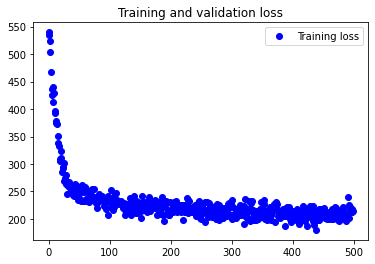

In [90]:
#Show loss
loss = VAE_train.history['loss']
#valid_loss = VAE_train.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, valid_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [91]:
#Check if Encoder has same weights with "encoder" in VAE
Encoder.get_weights()[0][1]


array([[[-0.00150408,  0.17984098, -0.07459477,  0.00617687,
         -0.14892867, -0.19367063,  0.037238  ,  0.08138346,
          0.07963379, -0.23808736,  0.1617715 ,  0.22244702,
          0.06574605,  0.06482422, -0.1502634 , -0.07835463,
          0.16315271,  0.15445596, -0.02058679,  0.06449388,
         -0.15176123,  0.19926055,  0.07405771, -0.00382681,
         -0.03617478,  0.0537807 ,  0.09484895,  0.07788057,
         -0.01850113,  0.07033338,  0.15535362, -0.01453648]],

       [[ 0.1929946 ,  0.08333895, -0.03011601, -0.14439832,
          0.07484009, -0.1555993 , -0.2144654 , -0.14322445,
         -0.10771731, -0.20615529,  0.25788635,  0.05048826,
          0.10114273,  0.10996035, -0.05118669, -0.09347384,
          0.13523278, -0.04925286, -0.15157819,  0.17433313,
         -0.20056996,  0.05614542,  0.02867462,  0.16634682,
         -0.15685377,  0.15479533,  0.04592996,  0.07219617,
          0.26131034, -0.04841362,  0.03448675, -0.09989937]],

       [[ 0.009970

In [92]:
VAE_model.get_weights()[0][1]

array([[[-0.00150408,  0.17984098, -0.07459477,  0.00617687,
         -0.14892867, -0.19367063,  0.037238  ,  0.08138346,
          0.07963379, -0.23808736,  0.1617715 ,  0.22244702,
          0.06574605,  0.06482422, -0.1502634 , -0.07835463,
          0.16315271,  0.15445596, -0.02058679,  0.06449388,
         -0.15176123,  0.19926055,  0.07405771, -0.00382681,
         -0.03617478,  0.0537807 ,  0.09484895,  0.07788057,
         -0.01850113,  0.07033338,  0.15535362, -0.01453648]],

       [[ 0.1929946 ,  0.08333895, -0.03011601, -0.14439832,
          0.07484009, -0.1555993 , -0.2144654 , -0.14322445,
         -0.10771731, -0.20615529,  0.25788635,  0.05048826,
          0.10114273,  0.10996035, -0.05118669, -0.09347384,
          0.13523278, -0.04925286, -0.15157819,  0.17433313,
         -0.20056996,  0.05614542,  0.02867462,  0.16634682,
         -0.15685377,  0.15479533,  0.04592996,  0.07219617,
          0.26131034, -0.04841362,  0.03448675, -0.09989937]],

       [[ 0.009970

In [93]:
# Change the labels from categorical to one-hot encoding
train_label_one_hot = to_categorical(train_label)
test_label_one_hot = to_categorical(test_label)


# Display the change for category label using one-hot encoding
print('Original label:', train_label[0])
print('After conversion to one-hot:', train_label_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [94]:
train_X,valid_X,train_label,valid_label = train_test_split(train_x,train_label_one_hot,test_size=0.2,random_state=13)

In [95]:
train_X.shape , valid_X.shape , train_label.shape , valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [96]:
def fc(enco):
    #flat = Flatten()(enco)
    x = Dense(50, activation='relu')(enco)
    x = Dropout(0.2)(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(0.2)(x)

    out = Dense(10, activation='softmax')(x)
    return out

In [97]:
#Build model
input_X = Input(shape=(rows, cols, channels))
mean, log_sigma, latent_code = Encoder(input_X)
full_model = Model(input_X,fc(latent_code))

In [98]:
#Set all variables in Encoder become untrainable
for layer in Encoder.layers:
    layer.trainable = False

In [99]:
full_model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-5),metrics=['accuracy'])

In [100]:
full_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_13 (Functional)   [(None, 128), (None, 128) 887680    
_________________________________________________________________
dense_18 (Dense)             (None, 50)                6450      
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 30)                1530      
_________________________________________________________________
dropout_17 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)              

In [101]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=500,verbose=1,validation_data=(valid_X, valid_label))


Epoch 1/500
750/750 [==============================] - 3s 4ms/step - loss: 2.6681 - accuracy: 0.1195 - val_loss: 2.2273 - val_accuracy: 0.1833
Epoch 2/500
750/750 [==============================] - 2s 3ms/step - loss: 2.3738 - accuracy: 0.1661 - val_loss: 2.0166 - val_accuracy: 0.3008
Epoch 3/500
750/750 [==============================] - 2s 3ms/step - loss: 2.1716 - accuracy: 0.2220 - val_loss: 1.8518 - val_accuracy: 0.4169
Epoch 4/500
750/750 [==============================] - 2s 3ms/step - loss: 2.0133 - accuracy: 0.2789 - val_loss: 1.7061 - val_accuracy: 0.5098
Epoch 5/500
750/750 [==============================] - 3s 3ms/step - loss: 1.8723 - accuracy: 0.3388 - val_loss: 1.5711 - val_accuracy: 0.5896
Epoch 6/500
750/750 [==============================] - 2s 3ms/step - loss: 1.7531 - accuracy: 0.3910 - val_loss: 1.4457 - val_accuracy: 0.6407
Epoch 7/500
750/750 [==============================] - 2s 3ms/step - loss: 1.6442 - accuracy: 0.4405 - val_loss: 1.3301 - val_accuracy: 0.6703

Epoch 58/500
750/750 [==============================] - 2s 3ms/step - loss: 0.7139 - accuracy: 0.7393 - val_loss: 0.5209 - val_accuracy: 0.8122
Epoch 59/500
750/750 [==============================] - 2s 3ms/step - loss: 0.7151 - accuracy: 0.7406 - val_loss: 0.5191 - val_accuracy: 0.8137
Epoch 60/500
750/750 [==============================] - 2s 3ms/step - loss: 0.7101 - accuracy: 0.7434 - val_loss: 0.5182 - val_accuracy: 0.8137
Epoch 61/500
750/750 [==============================] - 2s 3ms/step - loss: 0.7100 - accuracy: 0.7428 - val_loss: 0.5162 - val_accuracy: 0.8148
Epoch 62/500
750/750 [==============================] - 2s 3ms/step - loss: 0.7038 - accuracy: 0.7439 - val_loss: 0.5142 - val_accuracy: 0.8150
Epoch 63/500
750/750 [==============================] - 3s 4ms/step - loss: 0.7059 - accuracy: 0.7404 - val_loss: 0.5137 - val_accuracy: 0.8138
Epoch 64/500
750/750 [==============================] - 2s 3ms/step - loss: 0.6996 - accuracy: 0.7422 - val_loss: 0.5121 - val_accuracy:

Epoch 115/500
750/750 [==============================] - 3s 3ms/step - loss: 0.6280 - accuracy: 0.7689 - val_loss: 0.4745 - val_accuracy: 0.8284
Epoch 116/500
750/750 [==============================] - 2s 3ms/step - loss: 0.6339 - accuracy: 0.7646 - val_loss: 0.4736 - val_accuracy: 0.8288
Epoch 117/500
750/750 [==============================] - 2s 3ms/step - loss: 0.6259 - accuracy: 0.7717 - val_loss: 0.4730 - val_accuracy: 0.8290
Epoch 118/500
750/750 [==============================] - 2s 3ms/step - loss: 0.6279 - accuracy: 0.7695 - val_loss: 0.4733 - val_accuracy: 0.8282
Epoch 119/500
750/750 [==============================] - 3s 3ms/step - loss: 0.6257 - accuracy: 0.7700 - val_loss: 0.4722 - val_accuracy: 0.8280
Epoch 120/500
750/750 [==============================] - 2s 3ms/step - loss: 0.6271 - accuracy: 0.7703 - val_loss: 0.4723 - val_accuracy: 0.8291
Epoch 121/500
750/750 [==============================] - 2s 3ms/step - loss: 0.6249 - accuracy: 0.7703 - val_loss: 0.4716 - val_ac

750/750 [==============================] - 2s 3ms/step - loss: 0.5900 - accuracy: 0.7828 - val_loss: 0.4529 - val_accuracy: 0.8356
Epoch 172/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5928 - accuracy: 0.7829 - val_loss: 0.4526 - val_accuracy: 0.8354
Epoch 173/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5913 - accuracy: 0.7839 - val_loss: 0.4521 - val_accuracy: 0.8338
Epoch 174/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5894 - accuracy: 0.7846 - val_loss: 0.4526 - val_accuracy: 0.8351
Epoch 175/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5891 - accuracy: 0.7824 - val_loss: 0.4518 - val_accuracy: 0.8339
Epoch 176/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5842 - accuracy: 0.7855 - val_loss: 0.4520 - val_accuracy: 0.8344
Epoch 177/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5895 - accuracy: 0.7850 - val_loss: 0.4507 - val_accuracy: 0.8347

750/750 [==============================] - 2s 3ms/step - loss: 0.5700 - accuracy: 0.7914 - val_loss: 0.4399 - val_accuracy: 0.8385
Epoch 228/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5720 - accuracy: 0.7916 - val_loss: 0.4398 - val_accuracy: 0.8386
Epoch 229/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5738 - accuracy: 0.7907 - val_loss: 0.4392 - val_accuracy: 0.8399
Epoch 230/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5714 - accuracy: 0.7910 - val_loss: 0.4383 - val_accuracy: 0.8398
Epoch 231/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5694 - accuracy: 0.7920 - val_loss: 0.4391 - val_accuracy: 0.8400
Epoch 232/500
750/750 [==============================] - 3s 4ms/step - loss: 0.5732 - accuracy: 0.7892 - val_loss: 0.4386 - val_accuracy: 0.8398
Epoch 233/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5675 - accuracy: 0.7934 - val_loss: 0.4386 - val_accuracy: 0.8404

750/750 [==============================] - 2s 3ms/step - loss: 0.5582 - accuracy: 0.7957 - val_loss: 0.4298 - val_accuracy: 0.8442
Epoch 284/500
750/750 [==============================] - 3s 3ms/step - loss: 0.5526 - accuracy: 0.7983 - val_loss: 0.4303 - val_accuracy: 0.8427
Epoch 285/500
750/750 [==============================] - 3s 4ms/step - loss: 0.5537 - accuracy: 0.7960 - val_loss: 0.4299 - val_accuracy: 0.8440
Epoch 286/500
750/750 [==============================] - 3s 3ms/step - loss: 0.5571 - accuracy: 0.7983 - val_loss: 0.4293 - val_accuracy: 0.8425
Epoch 287/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5522 - accuracy: 0.7971 - val_loss: 0.4290 - val_accuracy: 0.8442
Epoch 288/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5544 - accuracy: 0.7962 - val_loss: 0.4286 - val_accuracy: 0.8436
Epoch 289/500
750/750 [==============================] - 3s 4ms/step - loss: 0.5573 - accuracy: 0.7967 - val_loss: 0.4290 - val_accuracy: 0.8445

750/750 [==============================] - 2s 3ms/step - loss: 0.5469 - accuracy: 0.7980 - val_loss: 0.4232 - val_accuracy: 0.8471
Epoch 340/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5449 - accuracy: 0.7997 - val_loss: 0.4234 - val_accuracy: 0.8457
Epoch 341/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5454 - accuracy: 0.7992 - val_loss: 0.4227 - val_accuracy: 0.8460
Epoch 342/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5446 - accuracy: 0.8004 - val_loss: 0.4230 - val_accuracy: 0.8459
Epoch 343/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5383 - accuracy: 0.8021 - val_loss: 0.4232 - val_accuracy: 0.8451
Epoch 344/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5462 - accuracy: 0.8009 - val_loss: 0.4227 - val_accuracy: 0.8468
Epoch 345/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5417 - accuracy: 0.8030 - val_loss: 0.4226 - val_accuracy: 0.8467

750/750 [==============================] - 3s 3ms/step - loss: 0.5386 - accuracy: 0.8040 - val_loss: 0.4170 - val_accuracy: 0.8483
Epoch 396/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5378 - accuracy: 0.8047 - val_loss: 0.4169 - val_accuracy: 0.8480
Epoch 397/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5384 - accuracy: 0.8009 - val_loss: 0.4168 - val_accuracy: 0.8469
Epoch 398/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5373 - accuracy: 0.8009 - val_loss: 0.4174 - val_accuracy: 0.8465
Epoch 399/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5361 - accuracy: 0.8024 - val_loss: 0.4168 - val_accuracy: 0.8496
Epoch 400/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5371 - accuracy: 0.8033 - val_loss: 0.4174 - val_accuracy: 0.8488
Epoch 401/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5359 - accuracy: 0.8042 - val_loss: 0.4168 - val_accuracy: 0.8474

750/750 [==============================] - 2s 3ms/step - loss: 0.5318 - accuracy: 0.8057 - val_loss: 0.4117 - val_accuracy: 0.8503
Epoch 452/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5281 - accuracy: 0.8049 - val_loss: 0.4120 - val_accuracy: 0.8497
Epoch 453/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5283 - accuracy: 0.8068 - val_loss: 0.4126 - val_accuracy: 0.8493
Epoch 454/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5284 - accuracy: 0.8049 - val_loss: 0.4119 - val_accuracy: 0.8492
Epoch 455/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5259 - accuracy: 0.8094 - val_loss: 0.4116 - val_accuracy: 0.8493
Epoch 456/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5277 - accuracy: 0.8037 - val_loss: 0.4115 - val_accuracy: 0.8497
Epoch 457/500
750/750 [==============================] - 2s 3ms/step - loss: 0.5270 - accuracy: 0.8061 - val_loss: 0.4111 - val_accuracy: 0.8488

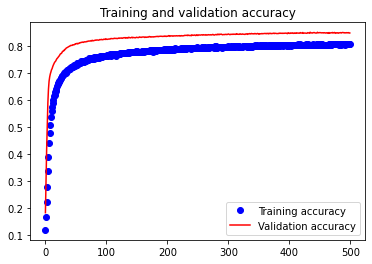

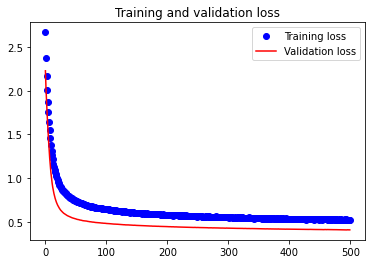

In [102]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [103]:
Encoder.get_weights()[0][1]

array([[[-0.00150408,  0.17984098, -0.07459477,  0.00617687,
         -0.14892867, -0.19367063,  0.037238  ,  0.08138346,
          0.07963379, -0.23808736,  0.1617715 ,  0.22244702,
          0.06574605,  0.06482422, -0.1502634 , -0.07835463,
          0.16315271,  0.15445596, -0.02058679,  0.06449388,
         -0.15176123,  0.19926055,  0.07405771, -0.00382681,
         -0.03617478,  0.0537807 ,  0.09484895,  0.07788057,
         -0.01850113,  0.07033338,  0.15535362, -0.01453648]],

       [[ 0.1929946 ,  0.08333895, -0.03011601, -0.14439832,
          0.07484009, -0.1555993 , -0.2144654 , -0.14322445,
         -0.10771731, -0.20615529,  0.25788635,  0.05048826,
          0.10114273,  0.10996035, -0.05118669, -0.09347384,
          0.13523278, -0.04925286, -0.15157819,  0.17433313,
         -0.20056996,  0.05614542,  0.02867462,  0.16634682,
         -0.15685377,  0.15479533,  0.04592996,  0.07219617,
          0.26131034, -0.04841362,  0.03448675, -0.09989937]],

       [[ 0.009970

In [104]:
full_model.get_weights()[0][1]

array([[[-0.00150408,  0.17984098, -0.07459477,  0.00617687,
         -0.14892867, -0.19367063,  0.037238  ,  0.08138346,
          0.07963379, -0.23808736,  0.1617715 ,  0.22244702,
          0.06574605,  0.06482422, -0.1502634 , -0.07835463,
          0.16315271,  0.15445596, -0.02058679,  0.06449388,
         -0.15176123,  0.19926055,  0.07405771, -0.00382681,
         -0.03617478,  0.0537807 ,  0.09484895,  0.07788057,
         -0.01850113,  0.07033338,  0.15535362, -0.01453648]],

       [[ 0.1929946 ,  0.08333895, -0.03011601, -0.14439832,
          0.07484009, -0.1555993 , -0.2144654 , -0.14322445,
         -0.10771731, -0.20615529,  0.25788635,  0.05048826,
          0.10114273,  0.10996035, -0.05118669, -0.09347384,
          0.13523278, -0.04925286, -0.15157819,  0.17433313,
         -0.20056996,  0.05614542,  0.02867462,  0.16634682,
         -0.15685377,  0.15479533,  0.04592996,  0.07219617,
          0.26131034, -0.04841362,  0.03448675, -0.09989937]],

       [[ 0.009970

In [105]:
test_eval = full_model.evaluate(test_x, test_label_one_hot, verbose=0)

In [106]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.40601325035095215
Test accuracy: 0.8525000214576721


In [107]:
predicted_classes = full_model.predict(test_x)


In [108]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


Found 8198 correct labels


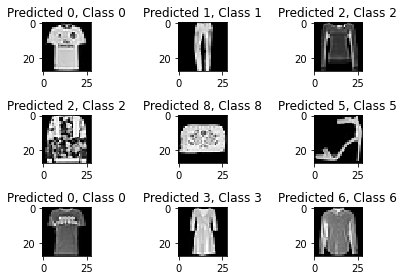

In [109]:
correct = np.where(predicted_classes==test_label)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_x[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_label[correct]))
    plt.tight_layout()

Found 1802 incorrect labels


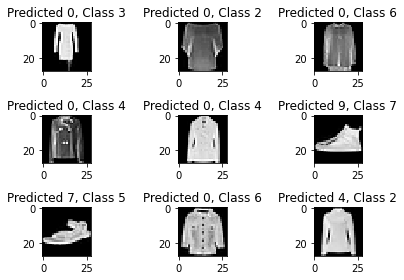

In [110]:
incorrect = np.where(predicted_classes!=test_label)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_x[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_label[incorrect]))
    plt.tight_layout()

In [111]:
num_classes = 10
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_label, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.47      0.95      0.62      1000
     Class 1       0.99      0.96      0.97      1000
     Class 2       0.86      0.66      0.75      1000
     Class 3       0.91      0.85      0.88      1000
     Class 4       0.80      0.73      0.76      1000
     Class 5       0.97      0.88      0.92      1000
     Class 6       0.87      0.36      0.51      1000
     Class 7       0.89      0.91      0.90      1000
     Class 8       0.97      0.96      0.96      1000
     Class 9       0.90      0.95      0.92      1000

    accuracy                           0.82     10000
   macro avg       0.86      0.82      0.82     10000
weighted avg       0.86      0.82      0.82     10000

